<a href="https://colab.research.google.com/github/davieir4/Data-Science/blob/main/Lista_2_Ci%C3%AAncia_de_Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Aquisição de Dados e Leitura**
Escreva um script em Python que leia o arquivo da rede de e-mails:

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import urllib.request

url = 'https://raw.githubusercontent.com/davieir4/Data-Science/refs/heads/main/email-Eu-core-temporal%20(1).txt'
with urllib.request.urlopen(url) as response:
    data = response.read().decode('utf-8')

lines = data.strip().split('\n')

G = nx.parse_edgelist(lines, delimiter=' ', nodetype=int, create_using=nx.DiGraph(), data=[('time', int)])

print(f"Número de nós: {G.number_of_nodes()}")
print(f"Número de arestas: {G.number_of_edges()}")


Número de nós: 986
Número de arestas: 24929




---


# **2. Visualização da Rede**
Desconsiderando o fator temporal, visualize a estrutura da rede social
direcionada por meio de um gráfico que ilustre sua organização.

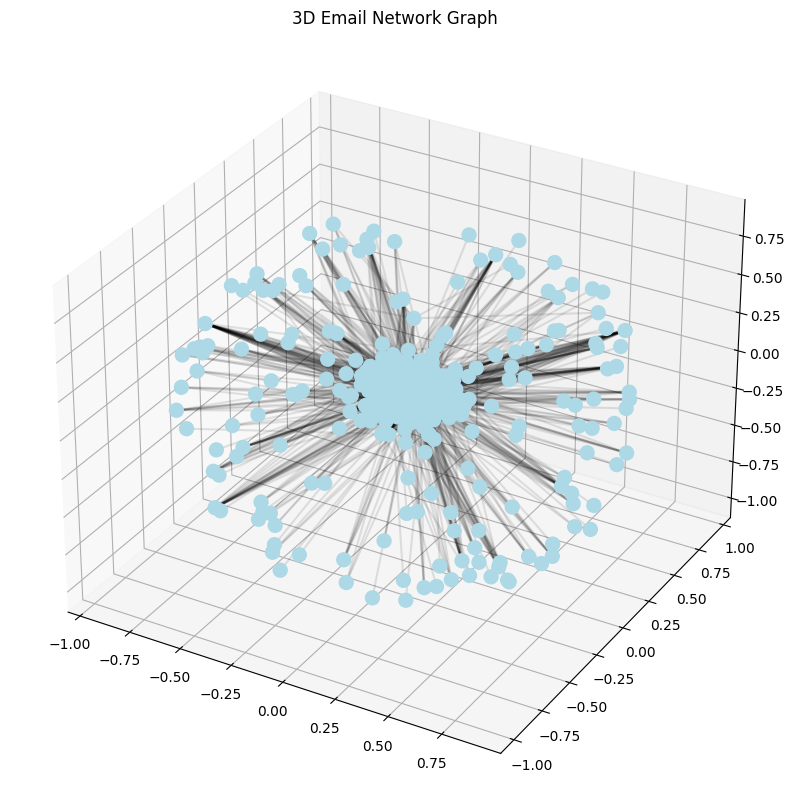

In [ ]:

from mpl_toolkits.mplot3d import Axes3D  # Import para plotagem em 3D


# Definir posições dos nós no layout de mola (spring layout) em 3D
pos = nx.spring_layout(G, dim=3)  # Define a dimensão do layout para 3D

# Inicia uma nova figura para o plot 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')  # Adiciona o subplot 3D

# Extrai as coordenadas 3D dos nós
x_vals = [pos[node][0] for node in G.nodes()]
y_vals = [pos[node][1] for node in G.nodes()]
z_vals = [pos[node][2] for node in G.nodes()]

# Desenha os nós em 3D
ax.scatter(x_vals, y_vals, z_vals, s=100, c='lightblue', alpha=1)

# Desenha as arestas em 3D
for edge in G.edges():
    x_vals_edge = [pos[edge[0]][0], pos[edge[1]][0]]
    y_vals_edge = [pos[edge[0]][1], pos[edge[1]][1]]
    z_vals_edge = [pos[edge[0]][2], pos[edge[1]][2]]
    ax.plot(x_vals_edge, y_vals_edge, z_vals_edge, color="black", alpha=0.1)

# Define título
plt.title("3D Email Network Graph")
plt.show()




---


# **3. Análise Global**
Utilizando ferramentas de análise de redes sociais, calcule a média dos
menores caminhos (shortest paths) entre os nós da rede. Com base nesse
valor, o que podemos concluir sobre a conectividade e a eficiência da
comunicação na rede?

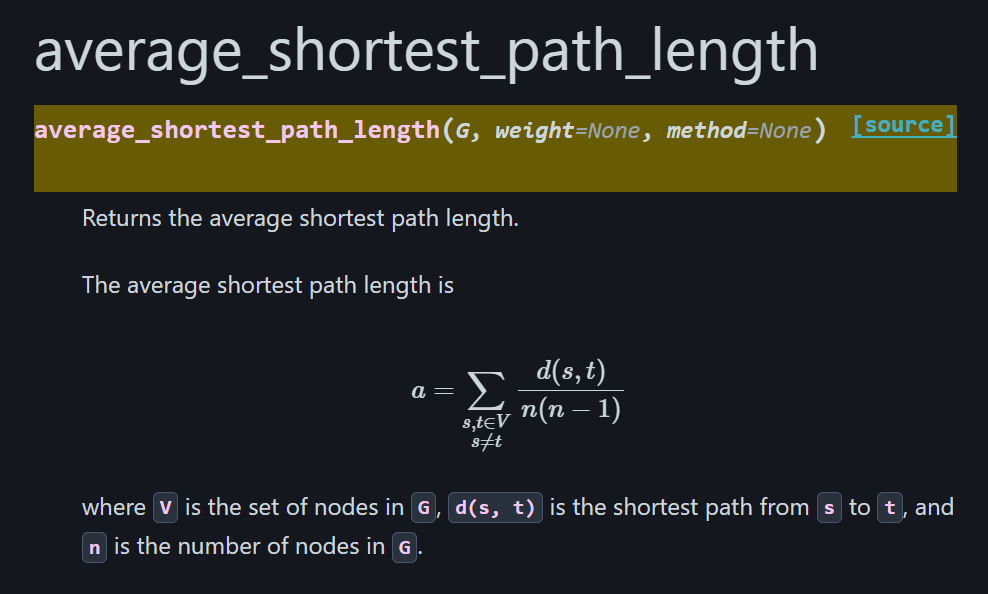

In [ ]:
avg_ShortP = nx.average_shortest_path_length(G)
print(avg_ShortP)

NetworkXError: Graph is not strongly connected.

Como trata-se de um DiGrafo, que não é fortemente conexo, necessitamos fazer alterações, nesse caso pegar a média de cada componente.

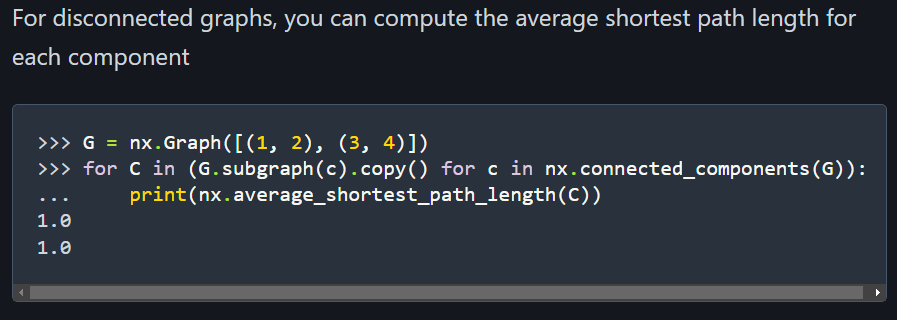

Aplicando o exemplo em nosso grafo, teremos:

In [ ]:
for C in (G.subgraph(c).copy() for c in nx.weakly_connected_components(G)):
    # Convert the subgraph to an undirected graph before calculating average path length
    C_undirected = C.to_undirected()
    print(nx.average_shortest_path_length(C_undirected))

2.586933824816466


Logo, concluímos que cada nó está, em média, a 2.6 arestas (aproximadamente) de distância. Em si tratando de uma rede de emails, podemos concluir que entre cada mensagem há **pelo menos um intermediador**. A mensagem de um emissor (s) passa, em média, por 2.6 trocas de email, até chegar em um distinatário (t).




---


# **4. Análise Estrutural**
Calcule os 5 nós com os maiores valores de Centralidade de Intermediação
(Betweenness Centrality). Com base nesses nós, interprete os resultados
alinhando o conceito dessa métrica ao contexto do conjunto de dados, que
representa o envio de e-mails entre diferentes entidades dentro de uma
instituição de pesquisa. O que esses nós indicam sobre a estrutura de
comunicação na instituição?

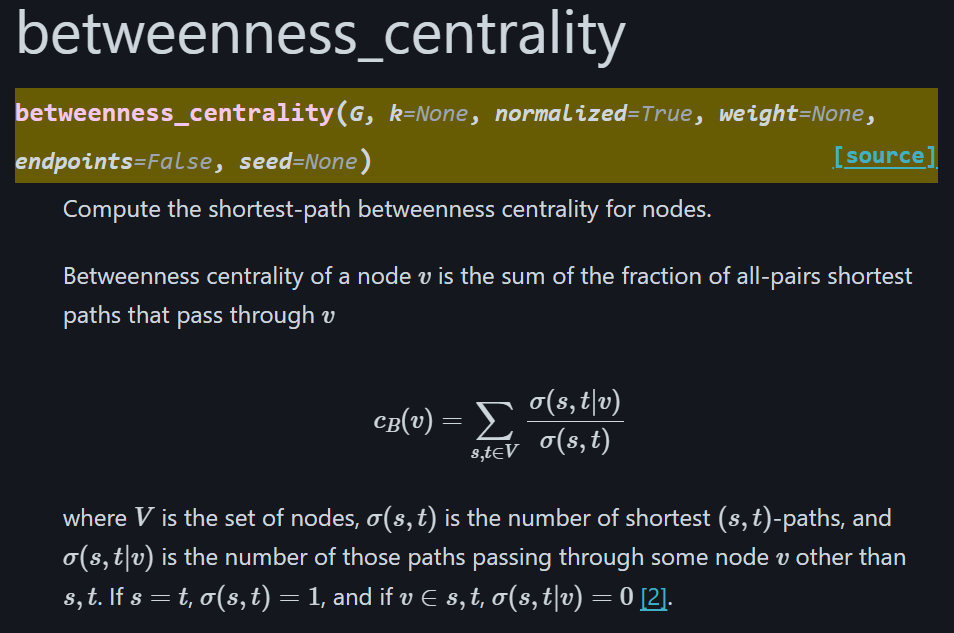

In [ ]:
import pandas as pd
import networkx as nx

betweenness_dict = nx.betweenness_centrality(G, normalized=True)

# Convertendo o dicionário em um DataFrame
df = pd.DataFrame(list(betweenness_dict.items()), columns=['Node', 'Betweenness'])

df_sorted = df.sort_values(by='Betweenness', ascending=False)


print(df_sorted.head(5).to_string(index=False))

 Node  Betweenness
   90     0.074931
  951     0.038892
    2     0.028036
  120     0.025488
  159     0.025466


Centralidade de Intermediação é uma medida central que determina a importância de um nó baseado em quão frequente ele é nos menores caminhos. O que essa análise nos revela é que os nós: 90, 951, 2, 120 e 159 são notáveis, por quê? Esse conjunto de nós representa os intermediadores mais eficientes do grafo G. Aplicando ao contexto, essa análise revela peças fundamentais na estrutura de circulação das mensagens (emails) de forma eficiente, compondo a forma ótima de contatar a maioria dos nós da rede.



---


# 5. Análise de Comunidades
 Utilizando o algoritmo de detecção de comunidades de Louvain, identifique o
nó com o maior grau de centralidade de chegada em cada comunidade. O que
podemos afirmar sobre esses nós? Sugestão: use a função louvain_partitions
do pacote NetworkX.

In [ ]:
!pip install python-louvain

In [ ]:
import networkx as nx
import community.community_louvain as community_louvain
import pandas as pd


# 1. Identificando as comunidades usando o algoritmo de Louvain
partition = community_louvain.best_partition(G.to_undirected())

# 2. Adicionando a informação de comunidade como atributo do nó
nx.set_node_attributes(G, partition, 'community')

# 3. Calculando a centralidade de chegada (in-degree centrality) para o grafo
in_degree_centrality = nx.in_degree_centrality(G)

# 4. Criando um DataFrame para centralidade e comunidades
df = pd.DataFrame({
    'Node': list(in_degree_centrality.keys()),
    'InDegreeCentrality': list(in_degree_centrality.values()),
    'Community': [partition[node] for node in G.nodes()]
})

# 5. Para cada comunidade, encontrando o nó com maior centralidade de chegada
max_centrality_per_community = df.loc[df.groupby('Community')['InDegreeCentrality'].idxmax()]

# Exibindo os nós com maior centralidade de chegada em cada comunidade
print(max_centrality_per_community.to_string(index=False))


 Node  InDegreeCentrality  Community
  383            0.116751          0
    2            0.124873          1
  534            0.092386          2
   61            0.144162          3
  915            0.109645          4
  499            0.069036          5
   90            0.214213          6
  159            0.180711          7


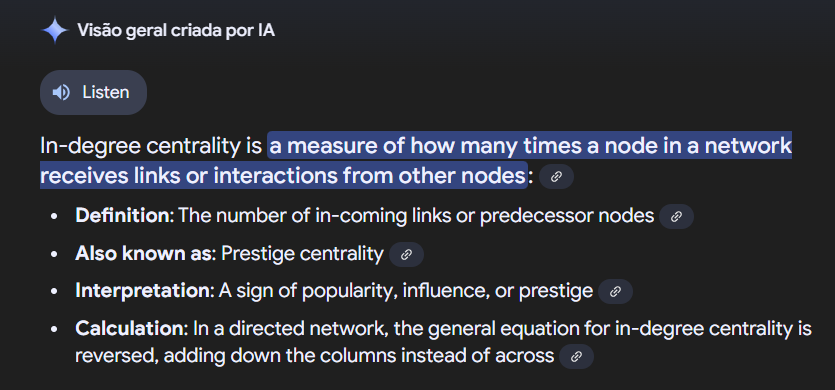

Usando a centralidade de chegada como uma métrica de préstigio, podemos dizer que os nós acima seriam os mais 'importantes' de cada comunidade, vamos chamá-los de "nós líderes". Esses nós representam grande influência dentro da rede.



---



# 6. Visualização Temporal
Com base nos nós selecionados na questão anterior e considerando o fator
temporal presente no conjunto de dados original, apresente graficamente o
número de arestas de entrada para cada um desses nós ao longo dos 803
dias.

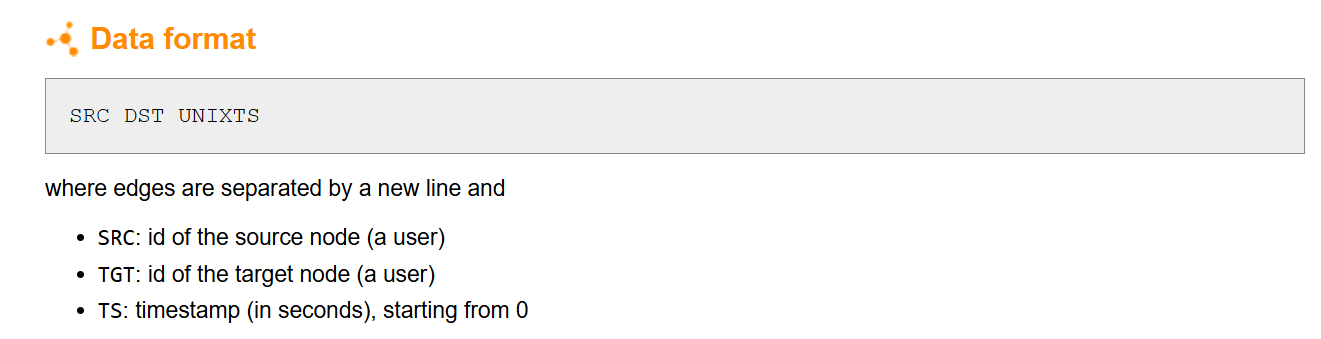

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

leaders = [383, 2, 534, 61, 915, 499, 90, 159] #líderes de comunidades observados na questão anterior
in_leaders = G.in_edges(leaders, data=True)
print(in_leaders)
'''
sns.lineplot(data=in_leaders)
plt.show()
'''

[(362, 383, {'time': 45134057}), (586, 383, {'time': 45142295}), (528, 383, {'time': 44351596}), (444, 383, {'time': 41426213}), (388, 383, {'time': 29437698}), (765, 383, {'time': 38927380}), (334, 383, {'time': 23967409}), (589, 383, {'time': 41930192}), (236, 383, {'time': 12985309}), (61, 383, {'time': 5500215}), (428, 383, {'time': 3314047}), (107, 383, {'time': 42036111}), (25, 383, {'time': 5470257}), (526, 383, {'time': 44271239}), (499, 383, {'time': 45125911}), (167, 383, {'time': 7042189}), (306, 383, {'time': 32187095}), (40, 383, {'time': 7893119}), (887, 383, {'time': 43753032}), (220, 383, {'time': 44202675}), (181, 383, {'time': 8243143}), (912, 383, {'time': 40827269}), (531, 383, {'time': 32274571}), (868, 383, {'time': 38401667}), (720, 383, {'time': 44453710}), (166, 383, {'time': 31758142}), (629, 383, {'time': 41327653}), (854, 383, {'time': 11104370}), (980, 383, {'time': 13008533}), (703, 383, {'time': 39968138}), (5, 383, {'time': 13010231}), (356, 383, {'time'

'\nsns.lineplot(data=in_leaders)\nplt.show()\n'

Atentando ao fato das peculiaridades do conjunto de dados, um tratamento deverá ser feito afim de representar os dados corretamente a respeito desses nós "lideres", portanto, uma nova leitura será feita realizando esse tratamento. Note que o Time Stamp está em segundos e queremos uma representação diária.

<ipython-input-95-58db39388cc6>:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_days = pd.DataFrame(index=range(803), columns=daily_counts.columns).fillna(0)


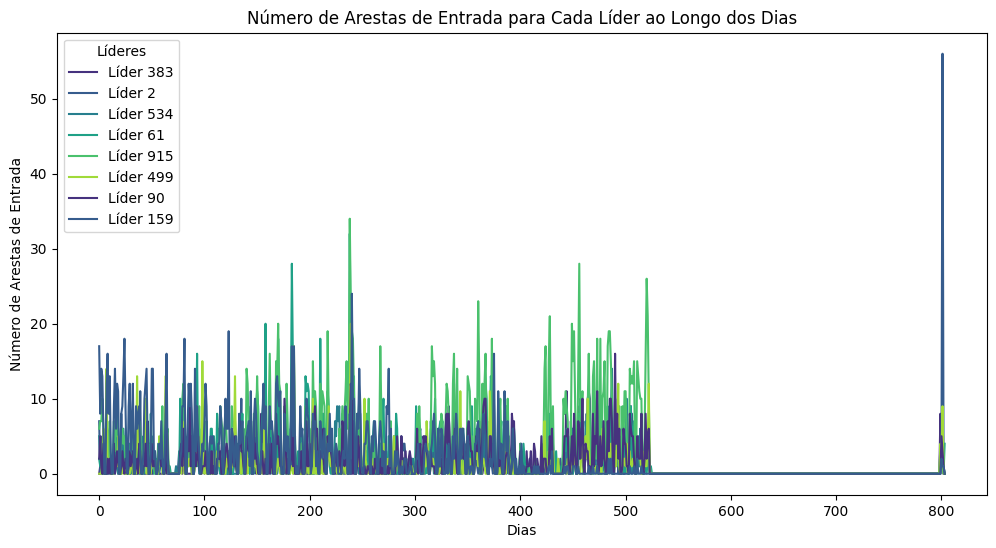

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("viridis")

# Definindo os líderes de interesse
leaders = [383, 2, 534, 61, 915, 499, 90, 159]
df = pd.DataFrame([line.split() for line in lines], columns=["SRC", "DST", "UNIXTS"])

df = df.astype({"SRC": int, "DST": int, "UNIXTS": int})

# Convertendo UNIXTS para dias, assumindo que o timestamp começa no dia 0
df['day'] = df['UNIXTS'] // (24 * 3600)

# Filtrando arestas destinadas a líderes
df_leaders = df[df['DST'].isin(leaders)]

# Conte as arestas de entrada por dia para cada líder
daily_counts = df_leaders.groupby(['day', 'DST']).size().unstack(fill_value=0)

# Garantindo que todos os dias estejam representados (mesmo com contagens zero)
all_days = pd.DataFrame(index=range(803), columns=daily_counts.columns).fillna(0)
daily_counts = all_days.add(daily_counts, fill_value=0).astype(int)

# Visualização dos dados
plt.figure(figsize=(12, 6))
for leader in leaders:
    sns.lineplot(x=daily_counts.index, y=daily_counts[leader], label=f"Líder {leader}")

plt.xlabel("Dias")
plt.ylabel("Número de Arestas de Entrada")
plt.title("Número de Arestas de Entrada para Cada Líder ao Longo dos Dias")
plt.legend(title="Líderes")
plt.show()

# Gráficos individuais para melhor visualização:

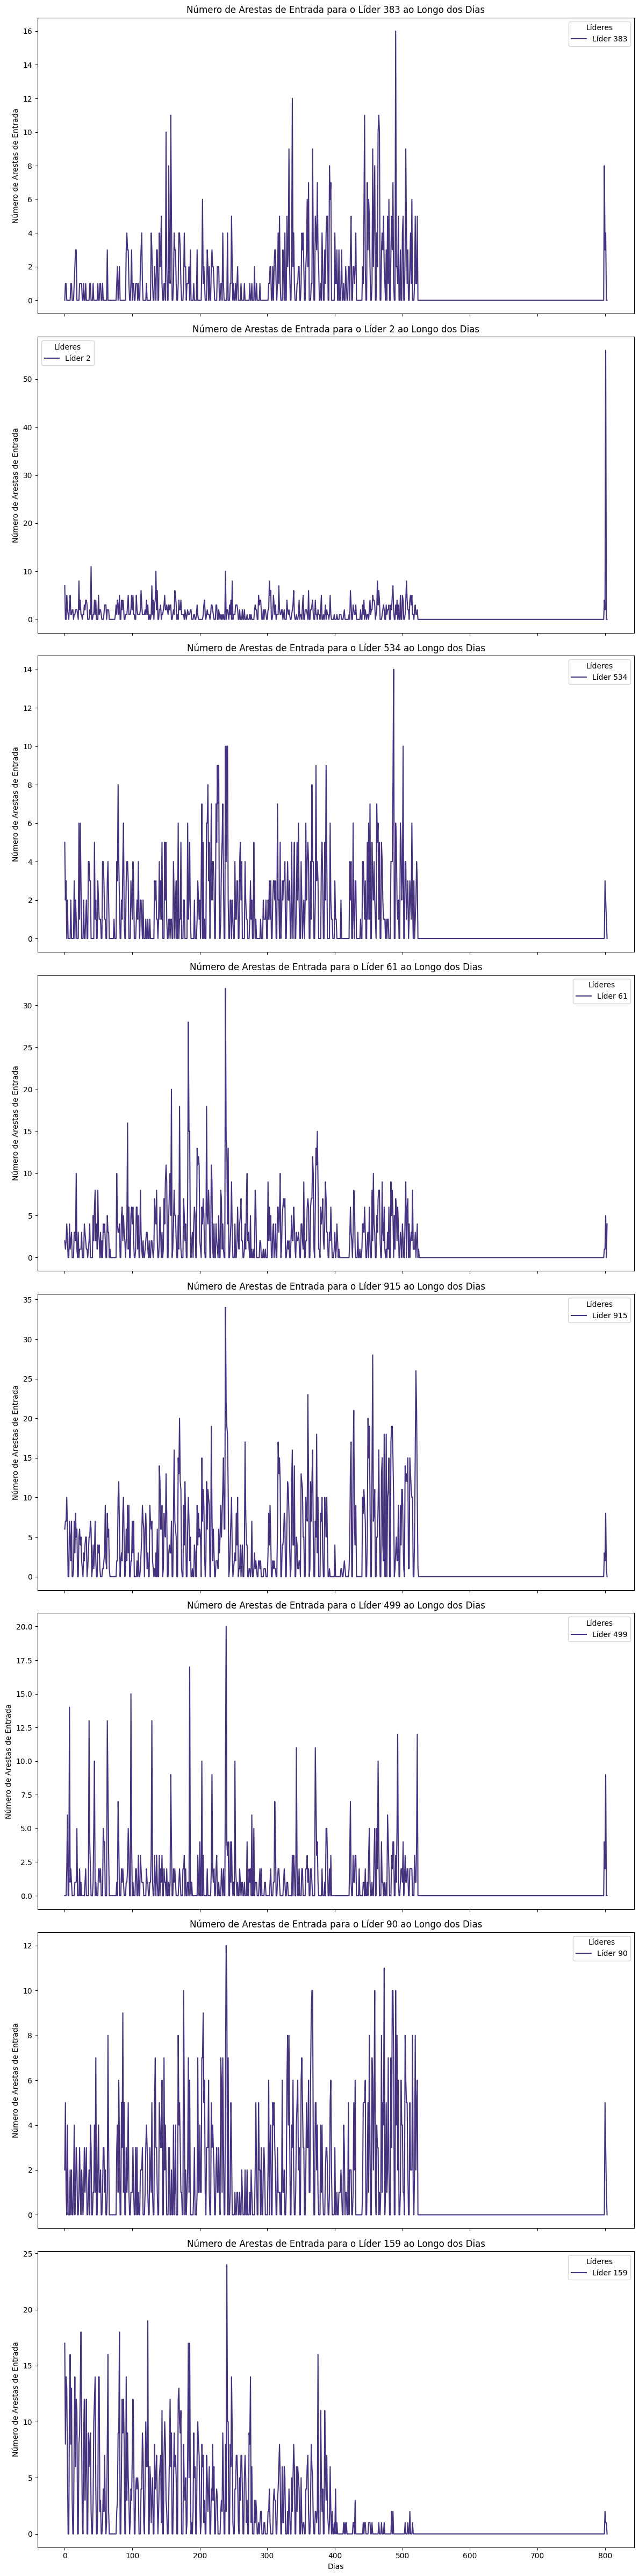

day
238    2270
239    2006
241    1987
240    1926
373    1693
       ... 
435      10
74        9
411       8
73        6
299       6
Name: count, Length: 526, dtype: int64


In [ ]:


fig, axes = plt.subplots(nrows=len(leaders), ncols=1, figsize=(12, 6 * len(leaders)), sharex=True)

for i, leader in enumerate(leaders):
    sns.lineplot(x=daily_counts.index, y=daily_counts[leader], ax=axes[i], label=f"Líder {leader}")
    axes[i].set_xlabel("Dias")
    axes[i].set_ylabel("Número de Arestas de Entrada")
    axes[i].set_title(f"Número de Arestas de Entrada para o Líder {leader} ao Longo dos Dias")
    axes[i].legend(title="Líderes")

plt.tight_layout()
plt.show()





---


# 7. Análise de Séries Temporais



**Escolha dois nós (A e B) da questão 5 e decomponha a série temporal
correspondente em tendência, sazonalidade e ruído. Compare as tendências e
sazonalidades entre os dois nós. Quais conclusões podemos tirar dessa
comparação?**

Vamos trabalhar com o nó 90 e o nó 534.

Escolher o período é uma etapa crucial no processo afim de uma boa decomposição, cabendo o uso de heurísticas, séries de fourier, etc.

Uma possibilidade também é T/step, isto é espaço anostral, espaço de tempo que será analisado, sobre o quanto ele progride na série, isto é o passo.

Empiricamente, o período escolhido foi correspondente a 803 (n dias) sobre 2, e funcionou bem.



<Figure size 1400x800 with 0 Axes>

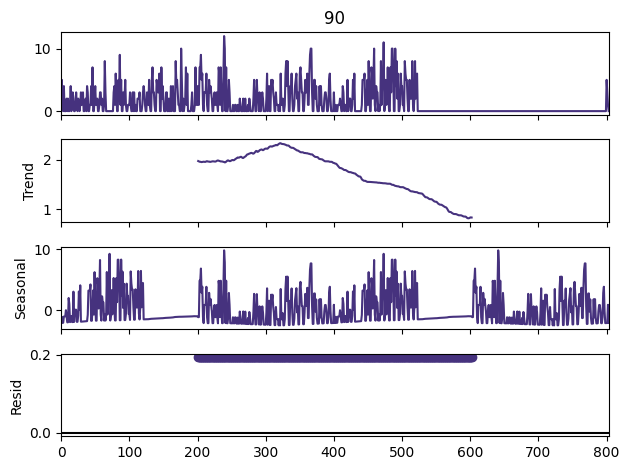

<Figure size 1400x800 with 0 Axes>

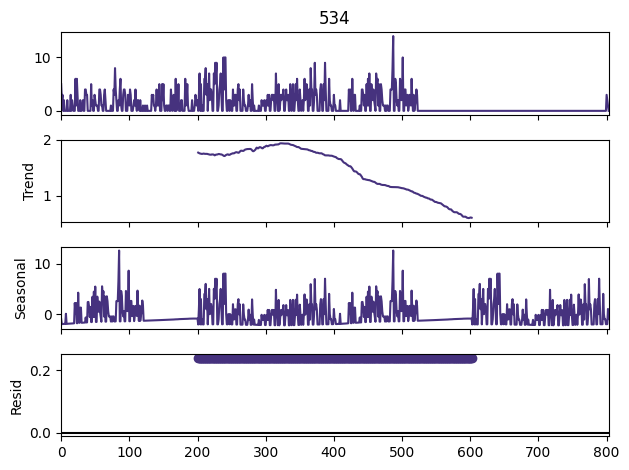

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

node_90_series = daily_counts[90]
node_534_series = daily_counts[534]

decompose_90 = seasonal_decompose(node_90_series, model='additive', period=402)
decompose_534 = seasonal_decompose(node_534_series, model='additive', period=402)

plt.figure(figsize=(14, 8))
plt.suptitle("Decomposição da Série Temporal do Nó 90")
decompose_90.plot()
plt.show()

plt.figure(figsize=(14, 8))
plt.suptitle("Decomposição da Série Temporal do Nó 534")
decompose_534.plot()
plt.show()


# Podemos notar semelhanças no comportamento dos dois nós, principalmente na tendência, ambos apresentam uma "downtrend", isto é, tendência de queda; contudo, a sazonalidade de ambos segue bastante ruidosa, indicando que nossa análise não foi capaz de prever um padrão na distribuição de emails aos "nós líderes" selecionados, embora o comportamento sazonal de ambas as séries seja semelhante.



---





# **8. Mudança de Comportamento**
Suponha que a instituição deseja alterar o fluxo de e-mails para reduzir a
demanda em A e B. Para isso, crie um novo nó na rede, denominado C.
Aleatoriamente, selecione 25% das arestas que vão de i para A (ou seja,
arestas do tipo (i, A)) e substitua A por C, resultando em arestas do tipo (i, C).
Repita o mesmo processo para as arestas que vão de i para B, substituindo
25% dessas arestas por (i, C).

In [ ]:
import pandas as pd
import numpy as np


# Definindo os nós A, B, e C
A, B, C = 90, 534, 1000

# Filtrando as arestas que vão para A e B

edges_to_A = df[df['DST'] == A]
edges_to_B = df[df['DST'] == B]

# Selecionando aleatoriamente 25% das arestas para A e B
edges_to_A_sample = edges_to_A.sample(frac=0.25, random_state=42)
edges_to_B_sample = edges_to_B.sample(frac=0.25, random_state=42)

# Substituindo o destino dessas amostras por C
edges_to_A_sample['DST'] = C
edges_to_B_sample['DST'] = C

# Atualizando o DataFrame original, removendo as arestas substituídas e adicionando as novas
df = pd.concat([
    df.drop(edges_to_A_sample.index),
    df.drop(edges_to_B_sample.index),
    edges_to_A_sample,
    edges_to_B_sample
])

# Resetando o índice do DataFrame atualizado
edges_df = df.reset_index(drop=True)




# **9. Análise da Mudança**
Repita o mesmo procedimento da questão 7 para os nós A, B e C.

<Figure size 1400x800 with 0 Axes>

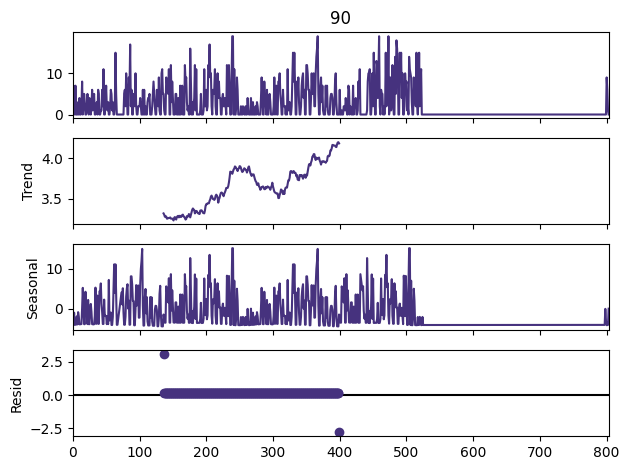

<Figure size 1400x800 with 0 Axes>

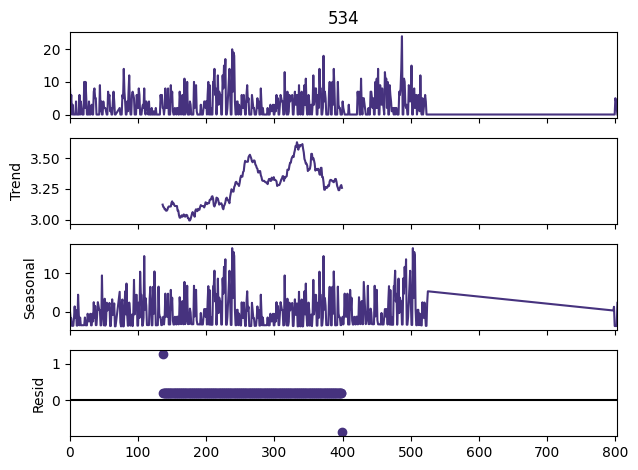

<Figure size 1400x800 with 0 Axes>

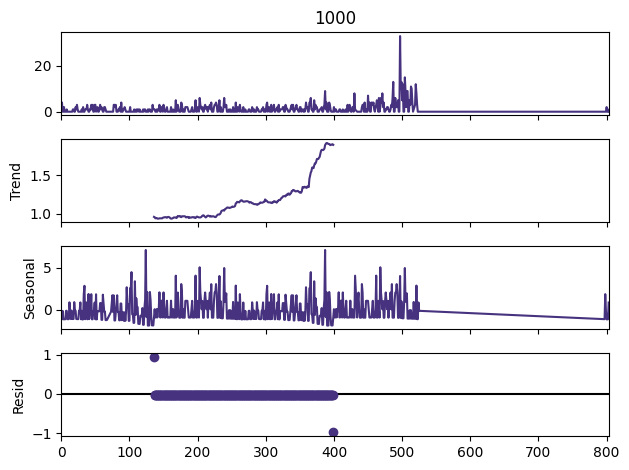

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


# Contar as arestas diárias para os nós A, B e C após a mudança
edges_df['day'] = edges_df['UNIXTS'] // (24 * 3600)

daily_counts = edges_df.groupby(['day', 'DST']).size().unstack(fill_value=0)
daily_counts = daily_counts.reindex(columns=[A, B, C], fill_value=0)

# Decompor as séries temporais para A, B e C
decompose_A = seasonal_decompose(daily_counts[A], model='additive', period=263)
decompose_B = seasonal_decompose(daily_counts[B], model='additive', period=263)
decompose_C = seasonal_decompose(daily_counts[C], model='additive', period=263)

# Plotar a decomposição para cada nó
plt.figure(figsize=(14, 8))
decompose_A.plot()
plt.show()

plt.figure(figsize=(14, 8))
decompose_B.plot()
plt.show()

plt.figure(figsize=(14, 8))
decompose_C.plot()
plt.show()




image.png

 o valor do período escolhido foi baseado no erro acima, assim como na questão 7, observando que deve-se completar dois ciclos, dividi o número total de observações por 2.

# **10. Tomada de Decisão baseada em Rede Social**
● Com base nas observações feitas na questão anterior, é possível
afirmar se o fluxo de chegadas de e-mails em A e B sofreu alterações?

● Utilize as métricas de redes sociais discutidas anteriormente e aplique
testes de hipóteses para fundamentar matematicamente a sua
conclusão.

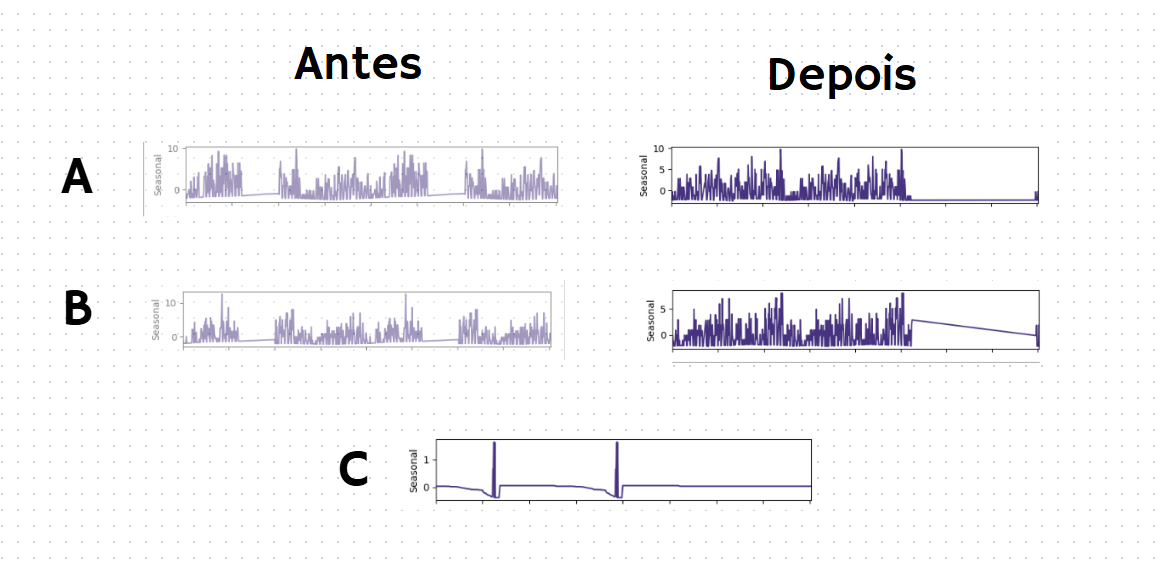

Como podemos observar, houve uma mudança principalmente na sazonalidade dos nós A e B, enquanto há dois picos muito claros no nó C indicando o recebimento do fluxo. Ademais, C demonstra tendência crescente indicando que a mudança no fluxo foi efetuada.

In [ ]:
import networkx as nx

in_degree_centrality = nx.in_degree_centrality(G)

in_degree_centrality_1000 = in_degree_centrality.get(1000, 0)

betweenness = nx.betweenness_centrality(G)
betweenness_1000 = betweenness.get(1000, 0)


in_degree_centrality_A = in_degree_centrality.get(A, 0)
in_degree_centrality_B= in_degree_centrality.get(B, 0)
in_degree_centrality_C = in_degree_centrality.get(C, 0)

print(f"In-Degree Centrality do nó A (90): {in_degree_centrality_A}")
print(f"In-Degree Centrality do nó B (534): {in_degree_centrality_B}")
print(f"In-Degree Centrality do nó C (1000): {in_degree_centrality_C}")
print('\n')
print(f"Betweenness Centrality do nó C): {betweenness_1000}")

In-Degree Centrality do nó A (90): 0.21421319796954316
In-Degree Centrality do nó B (534): 0.09238578680203047
In-Degree Centrality do nó C (1000): 0.014213197969543147


Betweenness Centrality do nó C): 0.00012985198850559633


**Analizando a medida de centralidade de chegada, vemos que C recebeu uma pequena parte do fluxo de A e B.**

Que por sua vez, demonstra uma singela taxa de intermediação herdada de A e B, praticamente nula.

# Teste de Hipótese

Se queremos provar SE houve mudança, nosso H0, ou hipótese nula será: não houve mudança de fluxo. Por conseguinte, nosso H1 será a antítese: houve mudança.

Podemos observar se houve mudança signitiva na média da centralidade de chegada de A e B.

Checando a questão obtemos os valores antigos da Centralidade de Chegada de A e B seguem:

#  A =            0.214213          
#  B =           0.092386          



Observamos que a centralidade de chegada A e B seguiu praticamente inalterada se comparada ao valor anterior. Em resumo, houve mudança? Sim. O suficiente para mudar drasticamente o fluxo de chegada do grafo? Não.